# pip install

In [1]:
#!pip install lightgbm scikit-learn xgboost plotnine pandas numpy seaborn matplotlib

# Imports

In [2]:
from gettext import install
from heapq import merge

import pandas as pd
import numpy as np

from itertools import product

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from pathlib import Path
from plotnine import *

# Data preparation
We will check for missing data, numerically encode categorical variables, and do some feature engineering in regards to potential oil price lags.

In [3]:
# Notebook location
NOTEBOOK_DIR = Path().resolve()
# Data directory
DATA_DIR = NOTEBOOK_DIR / "data"

#parse_dates=['date'] converts date values into datetime objects
train = pd.read_csv(DATA_DIR / "train.csv", parse_dates=['date'])
test = pd.read_csv(DATA_DIR / 'test.csv', parse_dates=['date'])
holidays_events = pd.read_csv(DATA_DIR / 'holidays_events.csv', parse_dates=['date'])
oil = pd.read_csv(DATA_DIR / 'oil.csv', parse_dates=['date'])
stores = pd.read_csv(DATA_DIR / 'stores.csv')
transactions = pd.read_csv(DATA_DIR / 'transactions.csv', parse_dates=['date'])
#data = pd.read_csv(DATA_DIR / 'data.csv', parse_dates=['date'])

### Check if there are missing dates in the train data

In [4]:
# Get the date range from earliest to latest in train data
date_range = pd.date_range(start=train['date'].min(), end=train['date'].max(), freq='D')

# Get unique dates in train data
train_dates = train['date'].unique()

# Find missing dates
missing_dates = date_range.difference(pd.DatetimeIndex(train_dates))

print(f"Total dates in range: {len(date_range)}")
print(f"Unique dates in train: {len(train_dates)}")
print(f"Missing dates: {len(missing_dates)}")
print(f"\nMissing dates:\n{missing_dates}")


Total dates in range: 1688
Unique dates in train: 1684
Missing dates: 4

Missing dates:
DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


We have 4 missing dates in total. This will cause problems in modelling, since timeseries models require a continuous flow time. Forecasting models require need the timeseries input to be complete, not missing any dates.  The following code will fix this and set the target value of sales as 0 on these days.

In [5]:
# Create a complete date range from train data
date_range = pd.date_range(start=train['date'].min(), end=train['date'].max(), freq='D')

# Get all unique combinations of store number and product family
stores_list = train['store_nbr'].unique()
unique_product_families = train['family'].unique()

# Create a MultiIndex with all combinations of date, store_nbr, and family
complete_index = pd.MultiIndex.from_tuples(
    product(date_range, stores_list, unique_product_families),
    names=['date', 'store_nbr', 'family']
)

# Create a complete dataframe
complete_df = pd.DataFrame(index=complete_index).reset_index()

# Merge with original train data
train_complete = complete_df.merge(
    train,
    on=['date', 'store_nbr', 'family'],
    how='left'
)

# Fill missing values i.e. sales and onpromotion with 0
train_complete['sales'] = train_complete['sales'].fillna(0)
train_complete['onpromotion'] = train_complete['onpromotion'].fillna(0)

# 4 missing dates, 54 stores, 33 product families i.e. 4 * 54 * 33 = 7128
print(f"Added records: {len(train_complete) - len(train)}")

train = train_complete

Added records: 7128


### Check missing oil dates

In [6]:
# Get the date range from earliest to latest in train and test data
date_range = pd.date_range(start=train['date'].min(), end=test['date'].max(), freq='D')

# Get unique dates in oil data
oil_dates = oil['date'].unique()

# Find missing dates
missing_dates = date_range.difference(pd.DatetimeIndex(oil_dates))

print(f"Total dates in range: {len(date_range)}")
print(f"Unique dates in oil: {len(oil_dates)}")
print(f"Missing dates: {len(missing_dates)}")

Total dates in range: 1704
Unique dates in oil: 1218
Missing dates: 486


We are once again missing dates, which disrupts our continuous timeseries. We will use the same method to fix it.

In [7]:
# Create complete date range for the data from train and test data
date_range = pd.date_range(start=train['date'].min(), end=test['date'].max(), freq='D')

# Create complete dataframe with all dates
oil_complete = pd.DataFrame({'date': date_range})

# Merge with original oil data
oil_complete = oil_complete.merge(
    oil, 
    on='date', 
    how='left'
)

# Forward fill (use last known price for missing dates)
oil_complete['dcoilwtico'] = oil_complete['dcoilwtico'].ffill()

# Backward fill for any remaining NaNs at the start
oil_complete['dcoilwtico'] = oil_complete['dcoilwtico'].bfill()

# Update oil dataframe
print(f"Number of records after filling missing oil data: {len(oil_complete)}")
print(f"Added records: {len(oil_complete) - len(oil)}")

oil = oil_complete

Number of records after filling missing oil data: 1704
Added records: 486


### Check transactions

In [8]:
# Total transactions count
total_transactions_count = len(train.groupby(["date", "store_nbr"])['sales'].sum())

print(f"Missing records from transactions: {total_transactions_count - len(transactions)}")


store_sales = train.groupby(['date', 'store_nbr'])['sales'].sum().reset_index()

# Merge transactions with sales
transactions_complete = transactions.merge(
    store_sales,
    on=['date', 'store_nbr'],
    how='outer'
).sort_values(by=['date', 'store_nbr'], ignore_index=True)

# For dates where sales are 0, set transactions to 0
transactions_complete.loc[transactions_complete["sales"].eq(0), "transactions"] = 0

# Interpolate missing transactions for each store
transactions_complete['transactions'] = transactions_complete.groupby('store_nbr')['transactions'].transform(
    lambda x: x.interpolate(method='linear')
)

# Round transactions to remove fractions from interpolation
transactions_complete['transactions'] = transactions_complete['transactions'].round().astype(int)

# Drop sales column
transactions_complete = transactions_complete.drop('sales', axis=1)

print(f"Added transactions: {len(transactions_complete) - len(transactions)}")

transactions = transactions_complete

Missing records from transactions: 7664
Added transactions: 7664


### Holidays

We want to create a 0/1 flag variable for holidays in our time series. This way we can account for extra store traffic during holidays quite simply.

In [9]:
# Clean holiday event descriptions and remove "Transfer" holidays, since they are actually not holidays.
holidays_events["description"] = holidays_events.apply(
    lambda x: x["description"].strip().lower().replace(x["locale_name"].lower(), ""), axis=1
).apply(
    #If the holiday is connected to football, we will just categorize it as futbol
    lambda x: "futbol" if "futbol" in x else x
).replace(
    #Removing unneeded words in the names of holidays
    r'\b(de|del|puente|traslado|recupero)\b', '', regex=True
).replace(
    #Removing +1, -2 etc type holidays since these are not actual holidays
    r'[+-]\d+', '', regex=True
).str.strip()
#Transfers are not actually holidays, they have been moved to a different day.
holidays_events = holidays_events[holidays_events["type"] != "Transfer"]

#Build 3 holiday tables for national, regional and local

h = holidays_events[['date', 'locale', 'locale_name']].copy()

# NATIONAL
#We only need to keep the date, since nationals take place all over the country
national = h[h['locale'] == 'National'][['date']].drop_duplicates()
national['national_holiday'] = 1

# REGIONAL → matches on state
#we have to keep the date and the region
regional = h[h['locale'] == 'Regional'][['date', 'locale_name']].drop_duplicates()
regional = regional.rename(columns={'locale_name': 'state'})
regional['regional_holiday'] = 1

# LOCAL → matches on city
#We have to keep the city and date
local = h[h['locale'] == 'Local'][['date', 'locale_name']].drop_duplicates()
local = local.rename(columns={'locale_name': 'city'})
local['local_holiday'] = 1

# --- Merge into data ---
data = pd.concat(
    [train, test], axis=0, ignore_index=True
).merge(
    transactions, on=['date', 'store_nbr'], how='left'
).merge(
    oil, on='date', how='left'
).merge(
    stores, on='store_nbr', how='left'
)
# Merge NATIONAL
data = data.merge(national, on='date', how='left')

# Merge REGIONAL
data = data.merge(regional, on=['date', 'state'], how='left')

# Merge LOCAL
data = data.merge(local, on=['date', 'city'], how='left')

# Final combined holiday flag column
data['holiday'] = (
    data[['national_holiday', 'regional_holiday', 'local_holiday']]
    .fillna(0)
    .max(axis=1)
    .astype(int)
)

# Cleanup
data = data.drop(columns=['national_holiday', 'regional_holiday', 'local_holiday'])

data['holiday'].value_counts()

holiday
0    2774310
1     262218
Name: count, dtype: int64

### Creating one, seven, 14 day lags for dcoilwtico
Since the effect of rising/falling oil prices takes time to set into effect we need lags for them.

In [10]:
# Sort by store_nbr, family, and date to ensure correct order within each group
data = data.sort_values(['store_nbr', 'family', 'date'])

# Create lag-1 column within each store-family combination
data['lag-1-dcoilwtico'] = data.groupby(['store_nbr', 'family'])['dcoilwtico'].shift(1)

# Create lag-2 column (7 days ago)
data['lag-7-dcoilwtico'] = data.groupby(['store_nbr', 'family'])['dcoilwtico'].shift(7)

# Create lag-3 column (14 days ago)
data['lag-14-dcoilwtico'] = data.groupby(['store_nbr', 'family'])['dcoilwtico'].shift(14)

# Backfill NaNs at the start of each group
data['lag-1-dcoilwtico'] = data.groupby(['store_nbr', 'family'])['lag-1-dcoilwtico'].bfill()
data['lag-7-dcoilwtico'] = data.groupby(['store_nbr', 'family'])['lag-7-dcoilwtico'].bfill()
data['lag-14-dcoilwtico'] = data.groupby(['store_nbr', 'family'])['lag-14-dcoilwtico'].bfill()

data = data.sort_values('date')

### Extract date features

In [11]:
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['day_of_week'] = data['date'].dt.dayofweek
data['day_of_year'] = data['date'].dt.dayofyear
data['week_of_year'] = data['date'].dt.isocalendar().week
data['is_weekend'] = (data['date'].dt.dayofweek >= 5).astype(int)

### Label Encoding for categorical features

Since many ML models cannot work with categorical features like "AUTOMOTIVE" etc, we have to numerically encode them for the model to work.

In [12]:
# Get all unique values for each categorical column from data
all_product_families = data['family'].unique()
all_cities = data['city'].unique()
all_states = data['state'].unique()
all_types = data['type'].unique()

# Initialize label encoders
le_product_family = LabelEncoder()
le_city = LabelEncoder()
le_state = LabelEncoder()
le_type = LabelEncoder()

# Fit on all unique values
le_product_family.fit(all_product_families)
le_city.fit(all_cities)
le_state.fit(all_states)
le_type.fit(all_types)

# Transform data dataframe
data['family'] = le_product_family.transform(data['family'])
data['city'] = le_city.transform(data['city'])
data['state'] = le_state.transform(data['state'])
data['type'] = le_type.transform(data['type'])

print("Label encoding complete!")
print(f"Family: {len(all_product_families)} categories")
print(f"City: {len(all_cities)} categories")
print(f"State: {len(all_states)} categories")
print(f"Type: {len(all_types)} categories")

Label encoding complete!
Family: 33 categories
City: 22 categories
State: 16 categories
Type: 5 categories


### Checking if datatypes are correct

In [13]:
data.dtypes

date                 datetime64[ns]
store_nbr                     int64
family                        int64
id                          float64
sales                       float64
onpromotion                 float64
transactions                float64
dcoilwtico                  float64
city                          int64
state                         int64
type                          int64
cluster                       int64
holiday                       int64
lag-1-dcoilwtico            float64
lag-7-dcoilwtico            float64
lag-14-dcoilwtico           float64
year                          int32
month                         int32
day                           int32
day_of_week                   int32
day_of_year                   int32
week_of_year                 UInt32
is_weekend                    int64
dtype: object

### Save final version of 'data' dataframe 

In [14]:
data.to_csv('./data/data.csv', index=False)

### Additional EDA

Before we move onto model fitting we should do some extra EDA to see what patterns we can notice in out data.


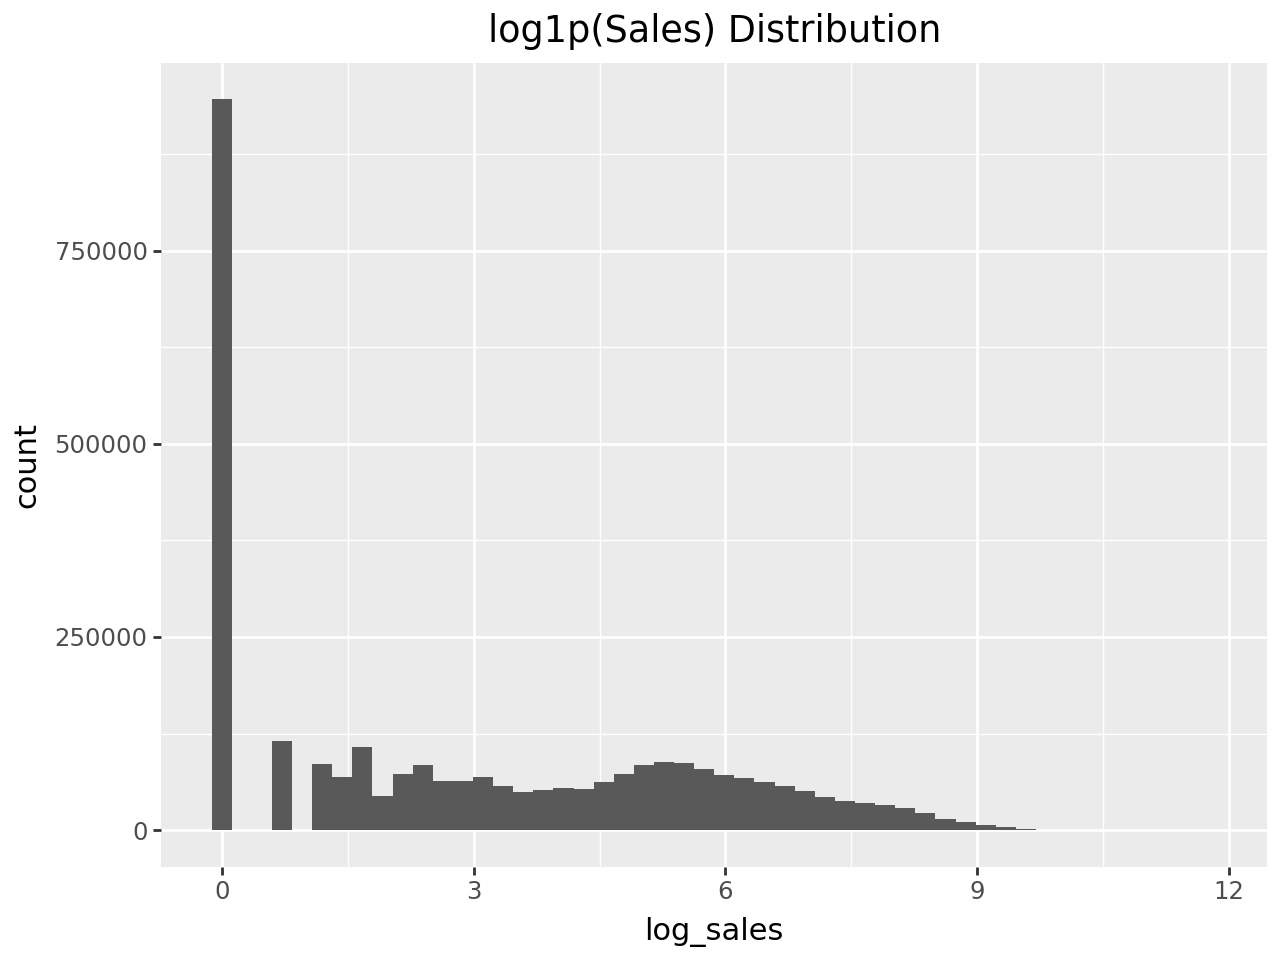

In [15]:
from plotnine import ggplot, aes, geom_histogram, ggtitle

#We should not look at the test data for EDA
eda_train = data[data['date'] < '2017-08-16'].copy()

eda_train["log_sales"] = np.log1p(eda_train["sales"]) #Cannot use simple log transformation because log(0) is undefined.

(ggplot(eda_train, aes("log_sales")) +
 geom_histogram(bins=50) +
 ggtitle("log1p(Sales) Distribution"))

I used a log transformation so the graph would be interpretable. We see, that by far the most common is zero sales for a certain category, which makes sense. Next I will look at sales by the day of the week.

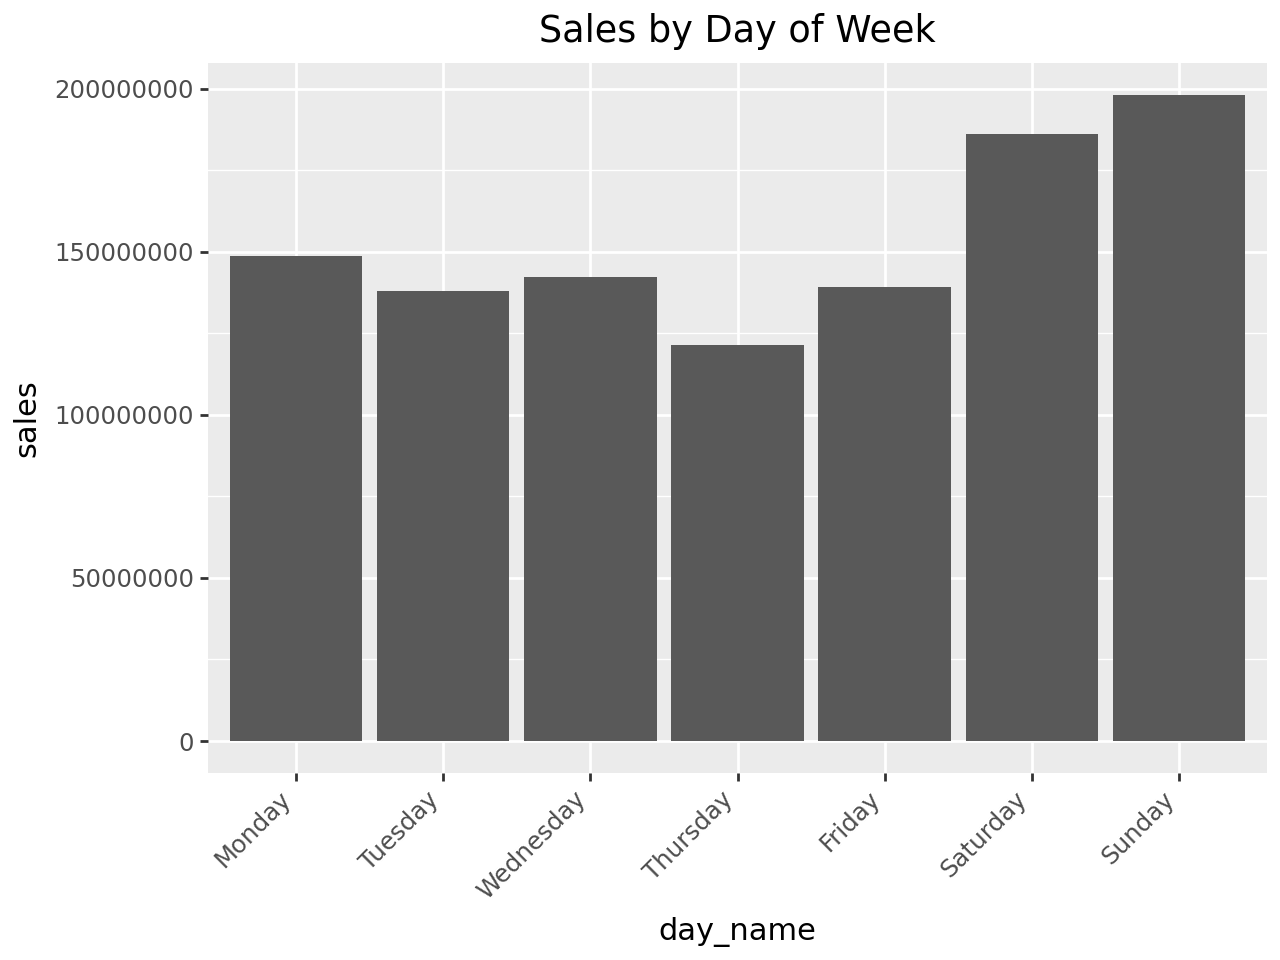

In [20]:
from plotnine import *

eda_train['day_name'] = eda_train['day_of_week'].map({
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
})

data_FE = eda_train.groupby("day_name", as_index=False)["sales"].sum()

(ggplot(data_FE, aes("day_name", "sales")) +
 geom_col() +
 scale_x_discrete(limits=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]) +
 theme(axis_text_x=element_text(angle=45, hjust=1)) +
 ggtitle("Sales by Day of Week"))

We see that most sales happen on the weekend, especially on Sunday, which is once again as expected, since people do their weekly grocery shopping on the weekends when they have free time. Let's look at sales by month next.

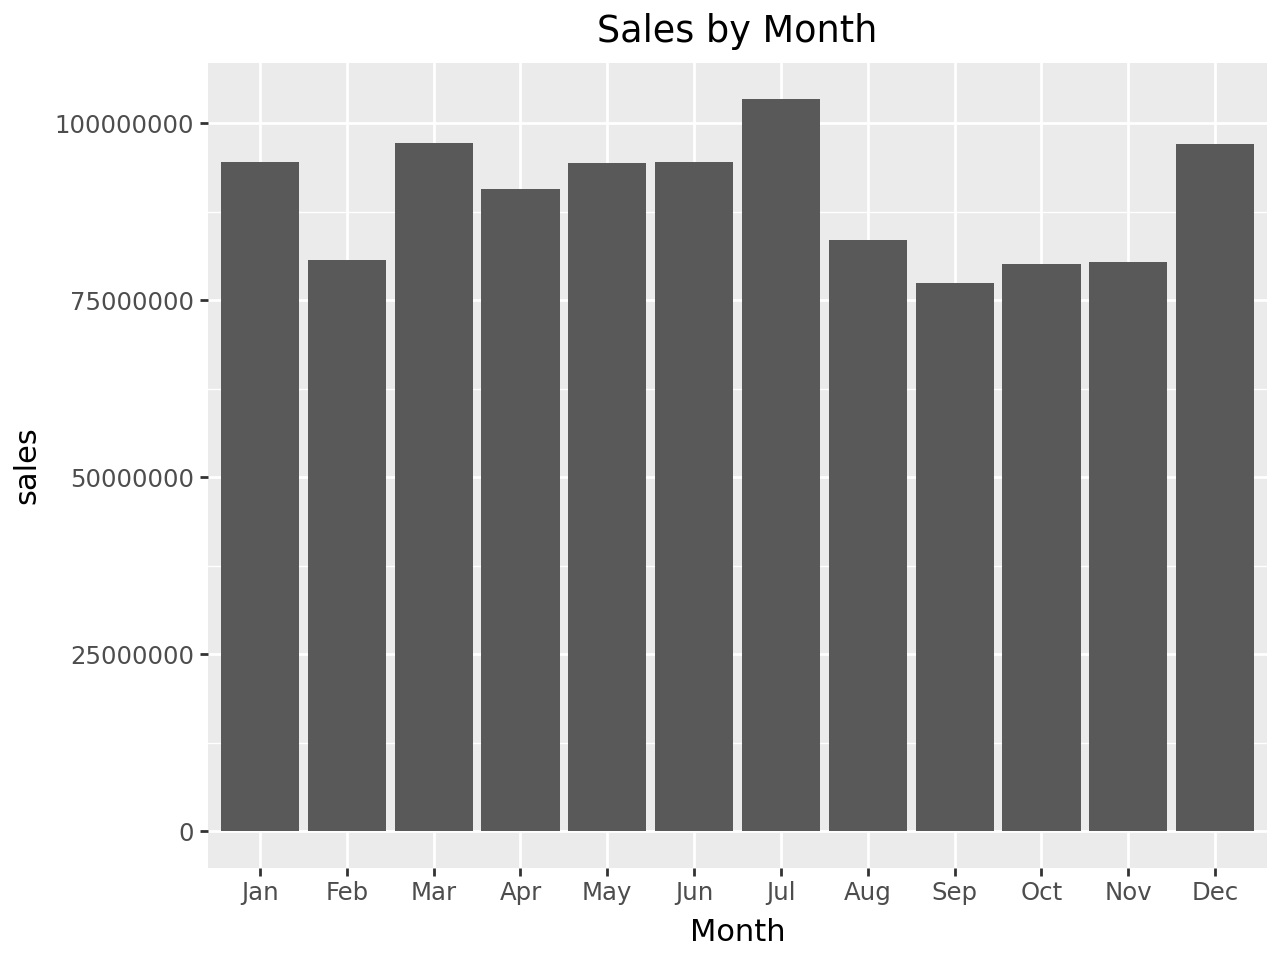

In [21]:
month_map = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr',
    5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
    9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}

eda_train['month_name'] = eda_train['month'].map(month_map)

data_FE = eda_train.groupby("month_name", as_index=False)["sales"].sum()

(ggplot(data_FE, aes("month_name", "sales")) +
 geom_col() +
 ggtitle("Sales by Month") + scale_x_discrete(limits=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]) + xlab("Month"))

We see that during autumn sales slow down and pick back up again in december and january. The peak is in July. Next we will look at the yearly trend.

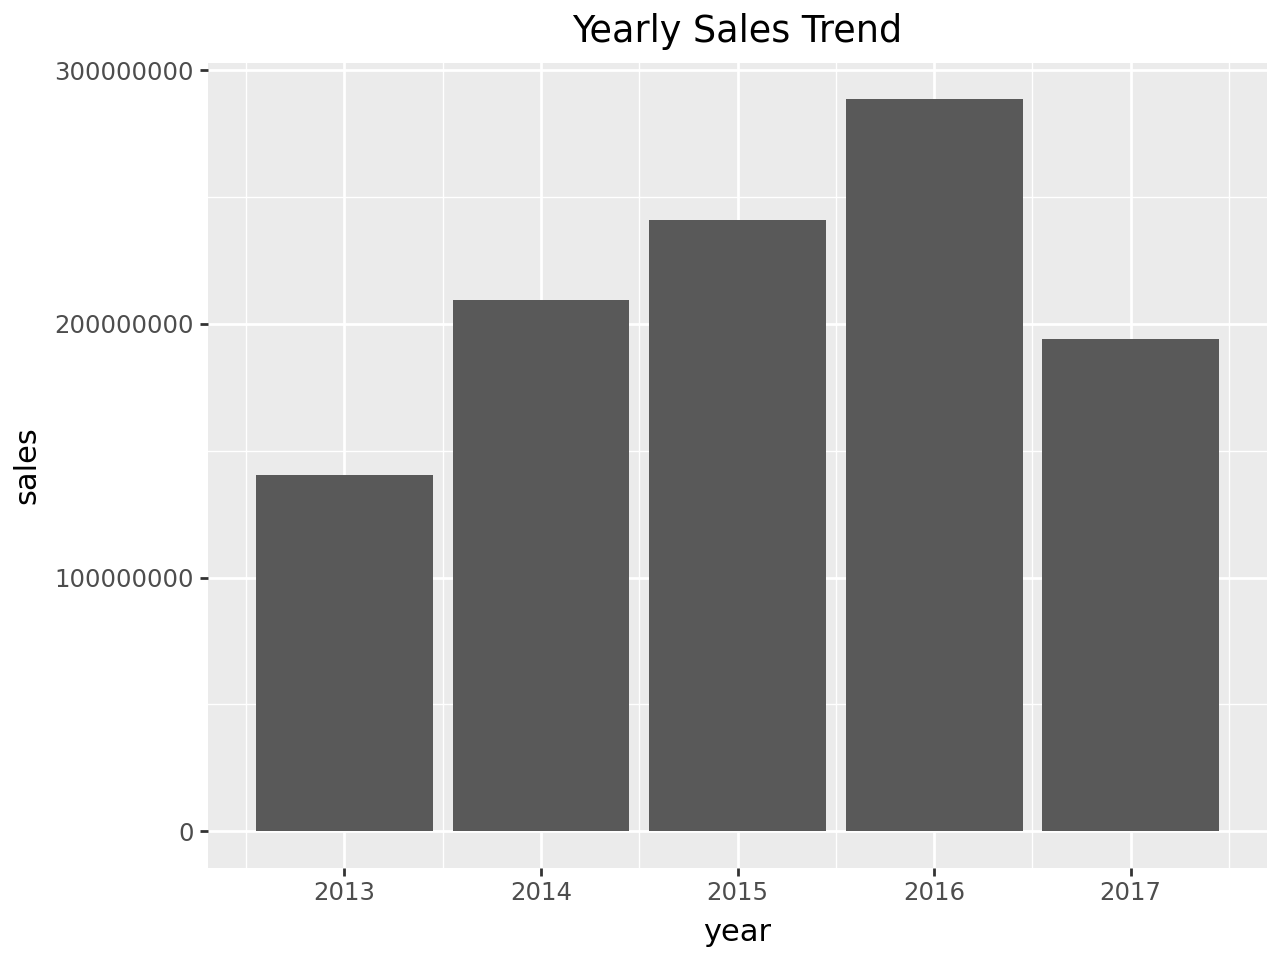

In [22]:
data_FE = eda_train.groupby("year", as_index=False)["sales"].sum()

(ggplot(data_FE, aes("year", "sales")) +
 geom_col() +
 ggtitle("Yearly Sales Trend"))

We see that sales have increase year over year, we don't yet have the full picture of 2017 though. Next we will take a look at sales by store.

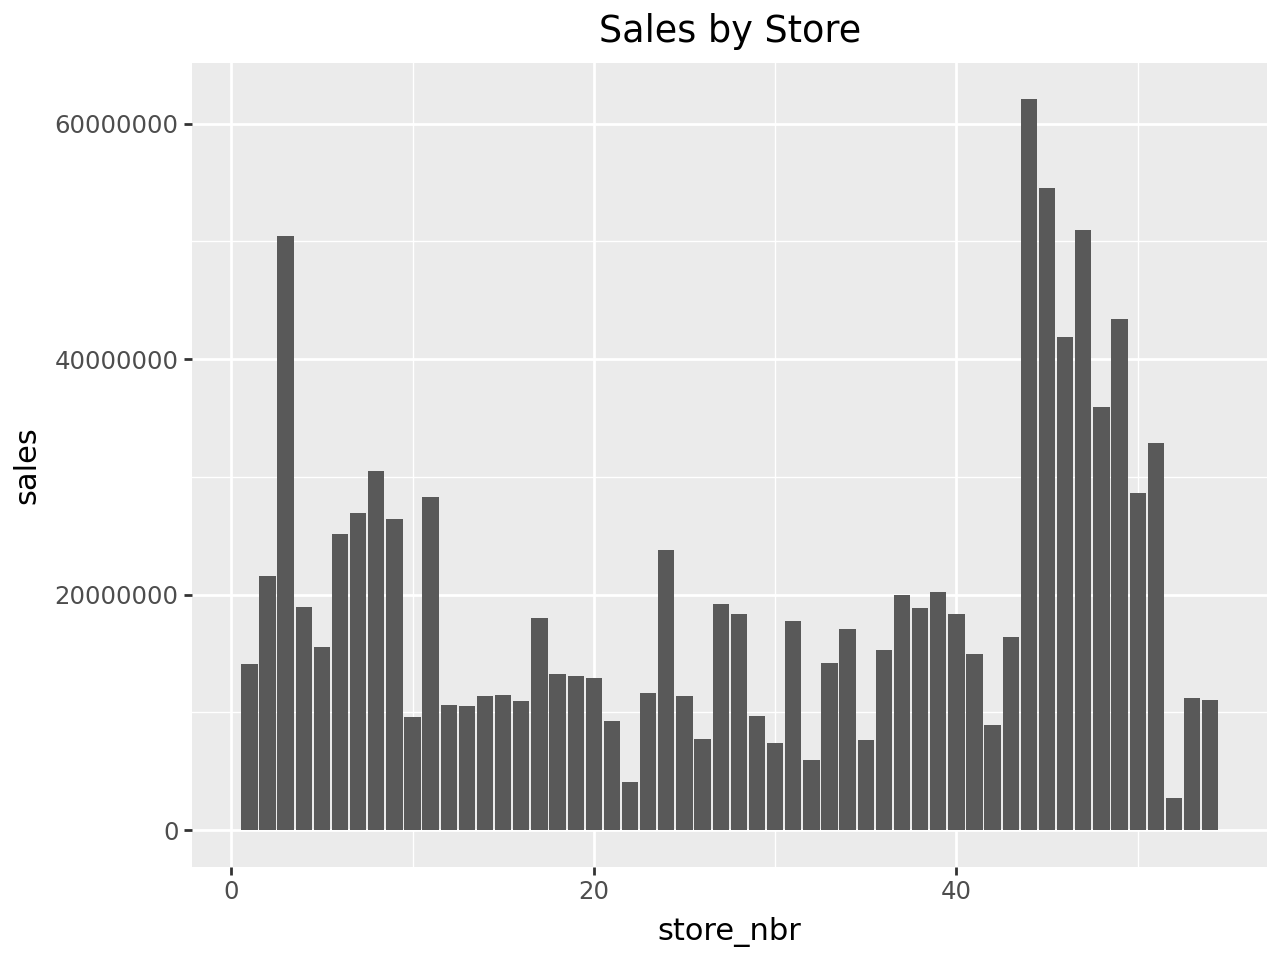

In [23]:
data_FE = eda_train.groupby("store_nbr", as_index=False)["sales"].sum()

(ggplot(data_FE, aes("store_nbr", "sales")) +
 geom_col() +
 ggtitle("Sales by Store"))

We see massive differences as expected, since stores located in denser population centres will naturally see more traffic. Additionally, we don't know if some of these stores are newly opened during the data collection timeframe and thus account for less sales in the dataset. Next we will look at sales by product family.

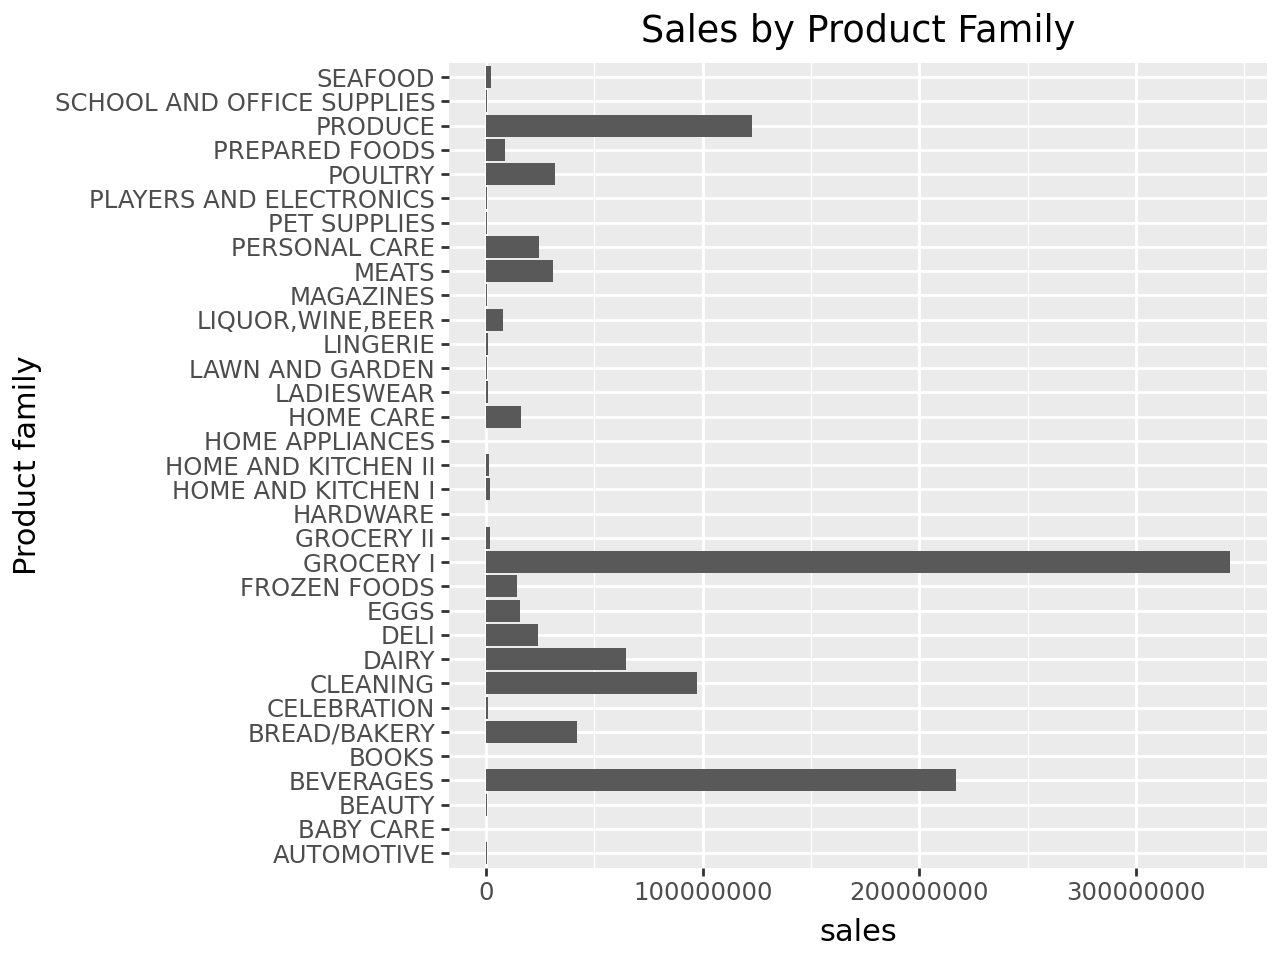

In [24]:
le_product_family = LabelEncoder()
le_product_family.fit(train['family'].unique())  # originaal nimed

# Reverse map: index → names
eda_train['family_name'] = le_product_family.inverse_transform(eda_train['family'])

data_FE = eda_train.groupby("family_name", as_index=False)["sales"].sum()

(ggplot(data_FE, aes("family_name", "sales")) +
 geom_col() +
 coord_flip() + xlab("Product family") +  # teeb horisontaalse bar graafiku, et nimed mahuvad
 ggtitle("Sales by Product Family"))

We have massive differences in sales between different product families. Groceries being obviously the most sold. Non-essential items make up a tiny amount of total sales. Next we will check what/how big of an effect do holidays have on sales.

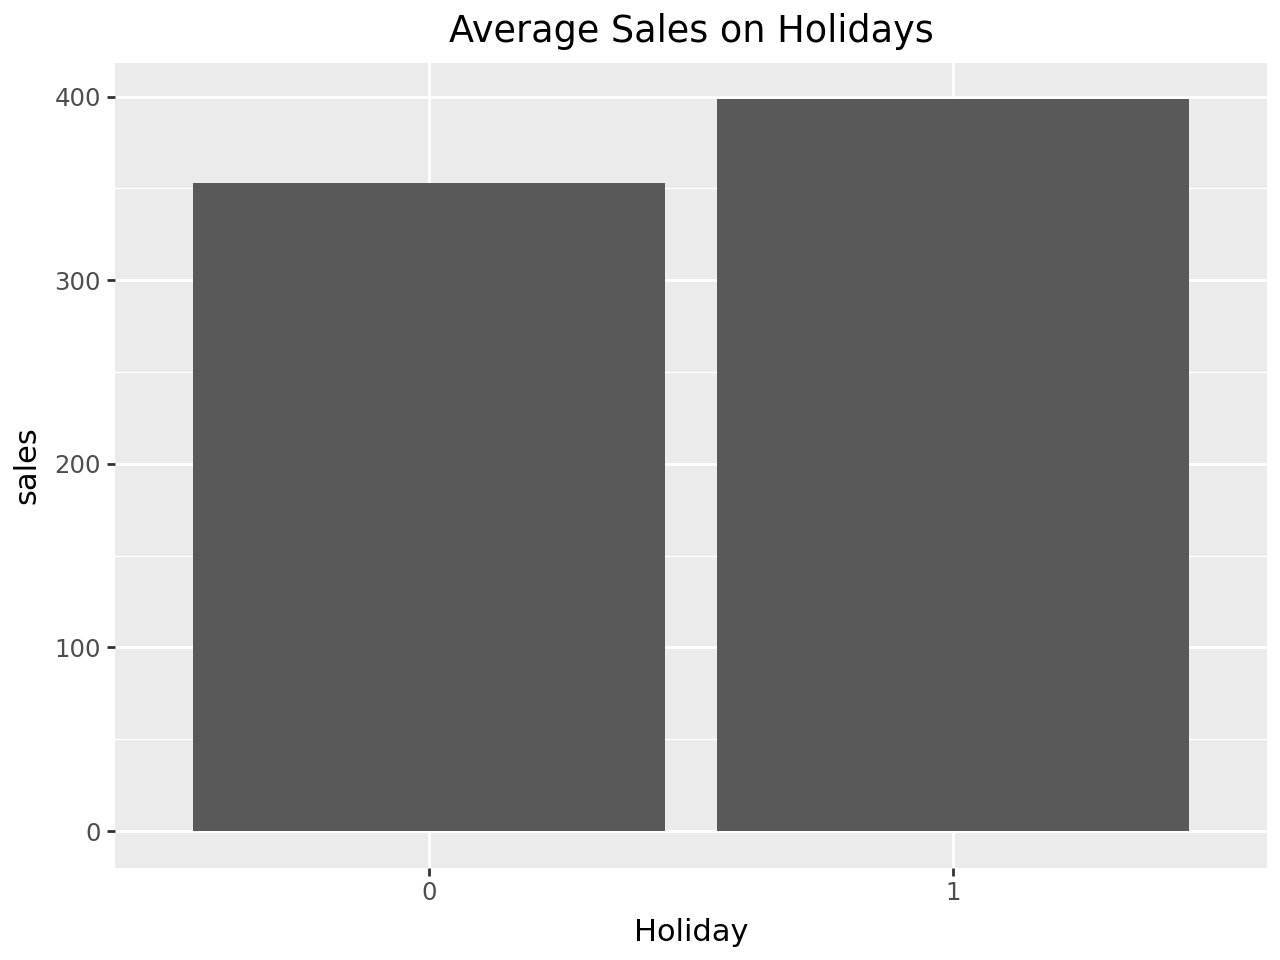

In [25]:
data_FE = eda_train.groupby("holiday", as_index=False)["sales"].mean()
(ggplot(data_FE, aes("factor(holiday)", "sales")) +
 geom_col() + xlab("Holiday") +
 ggtitle("Average Sales on Holidays"))

We see that holidays have slightly higher sales on average.

Next we will look at correlations to oil price.

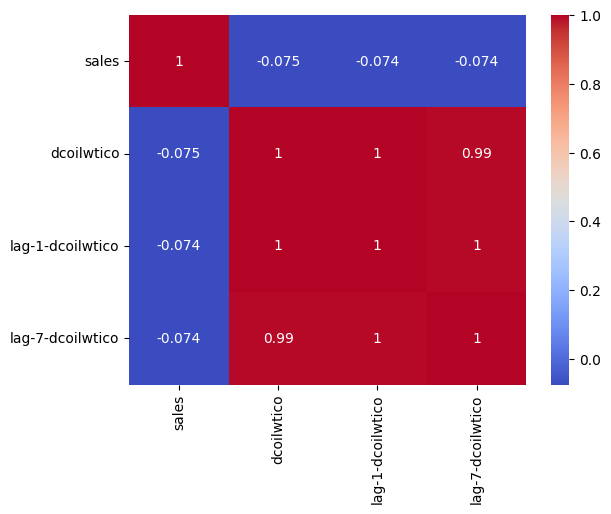

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(eda_train[["sales", "dcoilwtico", "lag-1-dcoilwtico", "lag-7-dcoilwtico"]].corr(),
            annot=True, cmap="coolwarm")
plt.show()

This does not tell us much. There appears to be some negative correlation between oil prices and sales. The relationship might be non-linear, then it will not show up properly as a correlation.

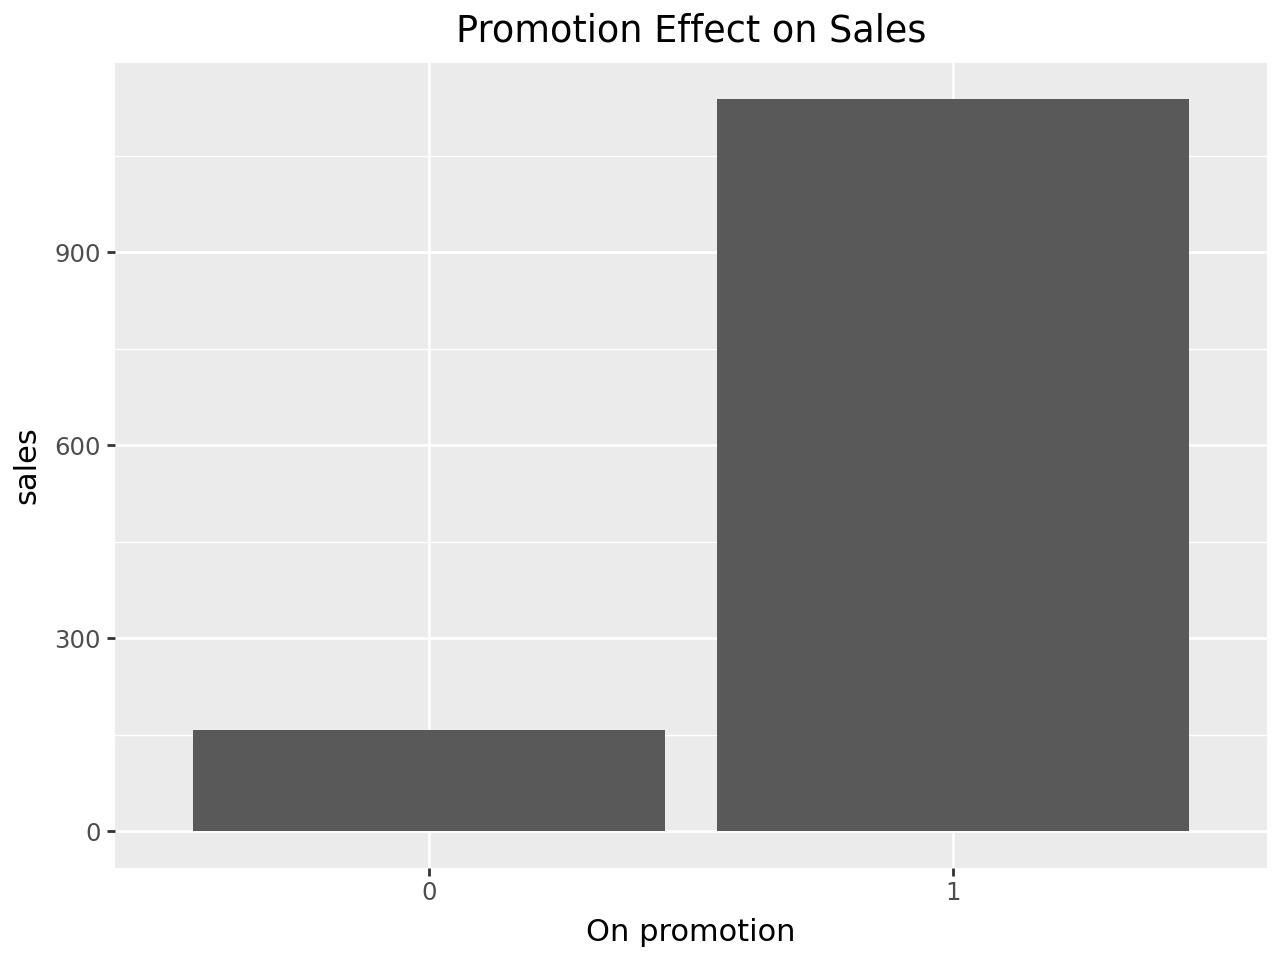

In [29]:
eda_train["promo_flag"] = (eda_train["onpromotion"] > 0).astype(int)

data_FE = eda_train.groupby("promo_flag", as_index=False)["sales"].mean()

(ggplot(data_FE, aes("factor(promo_flag)", "sales")) +
 geom_col() + xlab("On promotion") +
 ggtitle("Promotion Effect on Sales"))

We see that promotions increase sales massively. Lastly we will look at a seven-day rolling average of sales.

c:\Users\csl7027\AppData\Local\Programs\Python\Python314\Lib\site-packages\plotnine\geoms\geom_path.py:100: PlotnineWarning: geom_path: Removed 6 rows containing missing values.


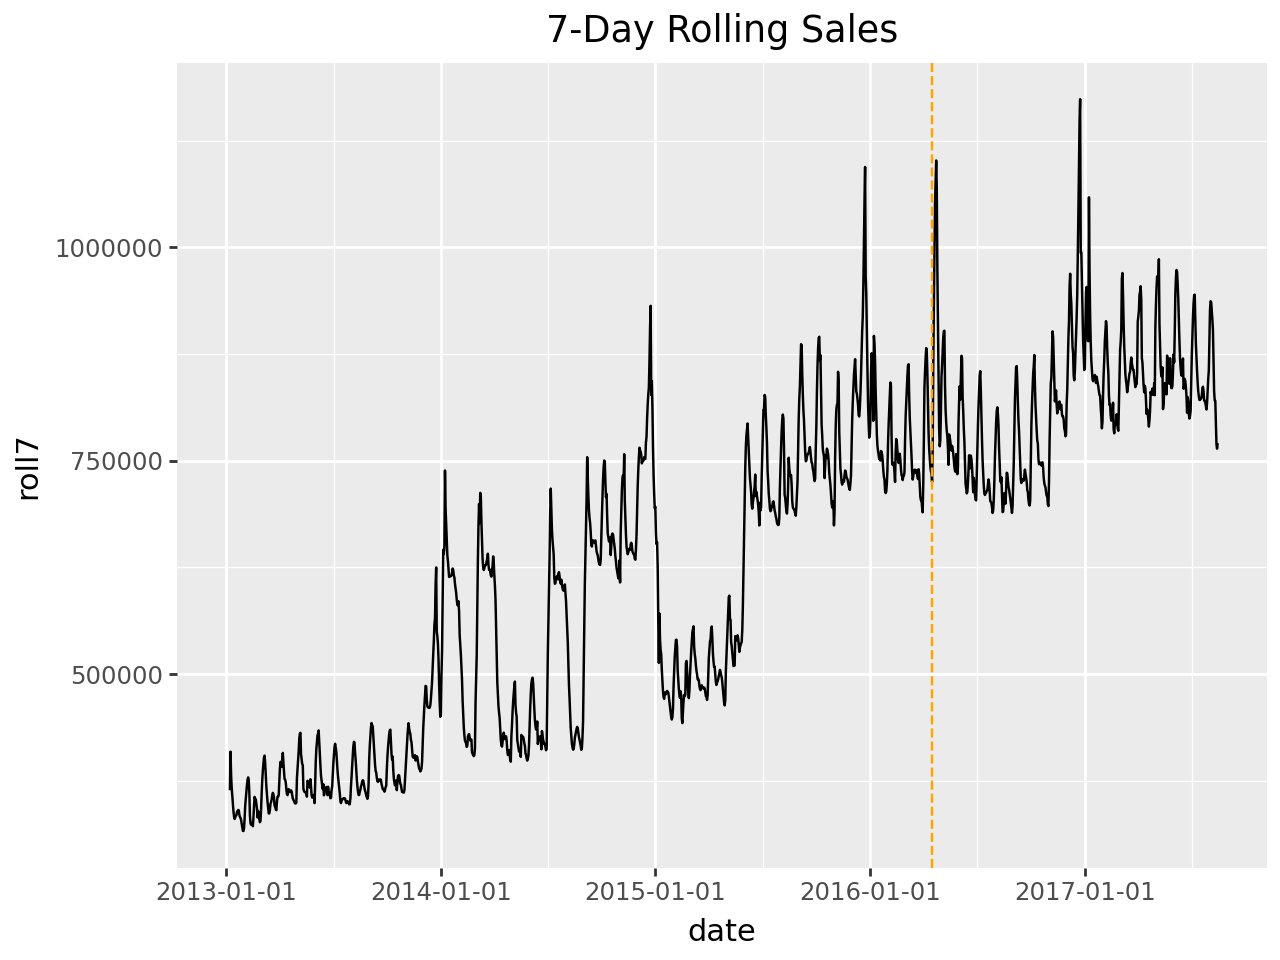

In [30]:
eda_ts = eda_train.groupby("date", as_index=False)["sales"].sum()
eda_ts["roll7"] = eda_ts["sales"].rolling(7).mean()
earthquake_date = pd.to_datetime("2016-04-16")

(ggplot(eda_ts, aes("date", "roll7")) +
 geom_line() + geom_vline(xintercept=earthquake_date, linetype='dashed', color='orange') +
 ggtitle("7-Day Rolling Sales"))

We see a massive drop in sales, which lasts a long time in the beginning of 2015. It might have something to do with oil prices. The orange line on the graph represents the earthquake which took place on 16th of April 2016. After that we do see some dropped sales activity. However, the drop is less significant than expected. Let's check.

c:\Users\csl7027\AppData\Local\Programs\Python\Python314\Lib\site-packages\plotnine\geoms\geom_path.py:100: PlotnineWarning: geom_path: Removed 6 rows containing missing values.
c:\Users\csl7027\AppData\Local\Programs\Python\Python314\Lib\site-packages\plotnine\geoms\geom_path.py:100: PlotnineWarning: geom_path: Removed 6 rows containing missing values.


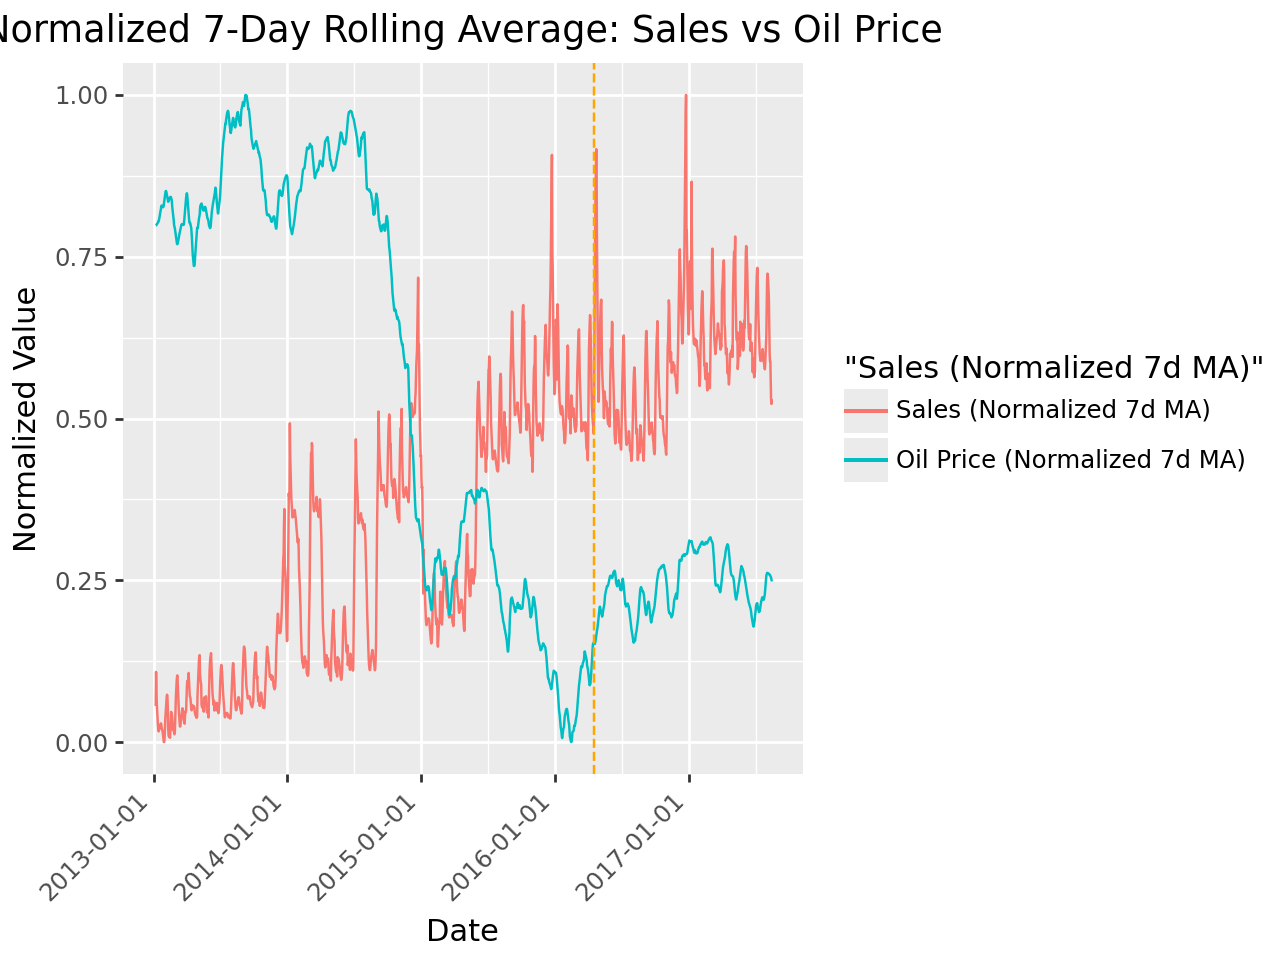

In [31]:
eda_ts = eda_train.groupby("date", as_index=False).agg({
    "sales": "sum",
    "dcoilwtico": "mean"
})
eda_ts["roll7_sales"] = eda_ts["sales"].rolling(7).mean()
eda_ts["roll7_oil"] = eda_ts["dcoilwtico"].rolling(7).mean()

from sklearn.preprocessing import MinMaxScaler

#We have to normalize the values since they are not in the same scale.
sc = MinMaxScaler()
eda_ts[["sales_norm", "oil_norm"]] = sc.fit_transform(
    eda_ts[["roll7_sales", "roll7_oil"]]
)

earthquake_date = pd.to_datetime("2016-04-16")

(
    ggplot(eda_ts) +
    geom_line(aes("date", "sales_norm", color='"Sales (Normalized 7d MA)"')) +
    geom_line(aes("date", "oil_norm", color='"Oil Price (Normalized 7d MA)"')) +
    geom_vline(xintercept=earthquake_date, linetype='dashed', color='orange') +
    ggtitle("Normalized 7-Day Rolling Average: Sales vs Oil Price") +
    xlab("Date") + ylab("Normalized Value") +
    theme(axis_text_x=element_text(rotation=45, hjust=1))
)

The sharp drop in 2015 can be attributed to a crash in oil prices. Although oil prices remained low for the remainder of the dataset, sales recovered and even surpassed the pre oil price drop levels.

### Additional feature engineering

From our EDA we got some useful insights which we can apply in feature engineering to hopefully increase the accuracy of our models.


### Day of week target encoding
As the last feature we will add DOW target encoding for sales. This feature allows for a model to look at each product family and store and see the average sales on monday, tuesday etc. This should in theory help the model tremendously. Because it knows the daily average per product family, per store.

In [32]:
data_FE = data.copy()
cut_off_date = pd.to_datetime("2017-08-16")

#For creating sales-lag
def shift_sales(df, days, cut_off_date):

    # Võta ainult minevik enne cut_off_date
    df_copy = df[df['date'] < cut_off_date].copy()

    # Nihuta kuupäeva tulevikku, et merge testiga töötaks
    df_copy['date'] += pd.Timedelta(days=days)

    # Nimeta tunnus
    df_copy.rename(columns={'sales': f'sales_{days}_days_ago'}, inplace=True)

    # Merge kogu df peale
    df_merged = df.merge(
        df_copy[['store_nbr', 'family', 'date', f'sales_{days}_days_ago']],
        on=['store_nbr', 'family', 'date'],
        how='left'
    )

    # Ffill, et täita alguse NA'd
    df_merged[f'sales_{days}_days_ago'].fillna(method='ffill', inplace=True, limit=days)

    return df_merged

def create_features(df):

    df = df.copy()

    # Sort for group operations
    df = df.sort_values(['store_nbr', 'family', 'date'])

    df["promo_flag"] = (df["onpromotion"] > 0).astype(int)

    # lags for 7, 14 days
    for lag in [7, 14]:
        df = shift_sales(df, lag, cut_off_date)

    return df

def compute_dow_stats(train_df):

    mask = ~(
        ((train_df['date'].dt.month == 12) & (train_df['date'].dt.day >= 12)) |
        ((train_df['date'].dt.month == 1)  & (train_df['date'].dt.day <= 5))
    )

    filtered = train_df[
        (train_df['date'] >= '2016-01-01') & (train_df['date'] < "2017-08-16") &
        mask
    ]

    stats = (
        filtered.groupby(['store_nbr', 'family', 'day_of_week'])['sales']
                .mean()
                .reset_index()
                .rename(columns={'sales': 'dow_mean_sales'})
    )

    train_df = train_df.merge(
        stats,
        on=['store_nbr', 'family', 'day_of_week'],
        how='left'
    )

    return train_df

data_FE = create_features(data_FE)
data_FE = compute_dow_stats(data_FE)

C:\Users\csl7027\AppData\Local\Temp\ipykernel_7008\3825868819.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
C:\Users\csl7027\AppData\Local\Temp\ipykernel_7008\3825868819.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


In [ ]:
data_FE.describe()

,date,store_nbr,family,id,sales,onpromotion,transactions,dcoilwtico,city,state,...,month,day,day_of_week,day_of_year,week_of_year,is_weekend,promo_flag,sales_7_days_ago,sales_14_days_ago,dow_mean_sales
count,3036528,3.036528e+06,3.036528e+06,3.029400e+06,3.008016e+06,3.036528e+06,3.008016e+06,3.036528e+06,3.036528e+06,3.036528e+06,...,3.036528e+06,3.036528e+06,3.036528e+06,3.036528e+06,3036528.0,3.036528e+06,3.036528e+06,3.020490e+06,3.032952e+06,3.036528e+06
mean,2015-05-02 12:00:00,2.750000e+01,1.600000e+01,1.514700e+06,3.569279e+02,2.637624e+00,1.553912e+03,6.771663e+01,1.255556e+01,8.796296e+00,...,6.238263e+00,1.572594e+01,2.998239e+00,1.744085e+02,25.386737,2.852113e-01,2.054643e-01,3.572214e+02,3.575138e+02,4.531868e+02
min,2013-01-01 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.619000e+01,0.000000e+00,0.000000e+00,...,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2014-03-02 18:00:00,1.400000e+01,8.000000e+00,7.573498e+05,0.000000e+00,0.000000e+00,9.270000e+02,4.640750e+01,8.000000e+00,6.000000e+00,...,3.000000e+00,8.000000e+00,1.000000e+00,8.600000e+01,13.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.037037e+00
50%,2015-05-02 12:00:00,2.750000e+01,1.600000e+01,1.514700e+06,1.100000e+01,0.000000e+00,1.330000e+03,5.328000e+01,1.400000e+01,1.000000e+01,...,6.000000e+00,1.600000e+01,3.000000e+00,1.710000e+02,25.0,0.000000e+00,0.000000e+00,1.100000e+01,1.100000e+01,2.703750e+01
75%,2016-07-01 06:00:00,4.100000e+01,2.400000e+01,2.272049e+06,1.950000e+02,0.000000e+00,1.975000e+03,9.571000e+01,1.800000e+01,1.200000e+01,...,9.000000e+00,2.300000e+01,5.000000e+00,2.590000e+02,38.0,1.000000e+00,0.000000e+00,1.950000e+02,1.950000e+02,2.676217e+02
max,2017-08-31 00:00:00,5.400000e+01,3.200000e+01,3.029399e+06,1.247170e+05,7.410000e+02,8.359000e+03,1.106200e+02,2.100000e+01,1.500000e+01,...,1.200000e+01,3.100000e+01,6.000000e+00,3.660000e+02,53.0,1.000000e+00,1.000000e+00,1.247170e+05,1.247170e+05,1.568074e+04
std,NaN,1.558579e+01,9.521906e+00,8.745126e+05,1.100829e+03,1.231906e+01,1.034145e+03,2.562034e+01,6.264737e+00,4.165021e+00,...,3.381744e+00,8.798776e+00,1.998972e+00,1.033947e+02,14.78707,4.515151e-01,4.040405e-01,1.100775e+03,1.100723e+03,1.251166e+03


We will greate a separate dataset, where we store categorical values as categorical dtypes. This can improve some Machine Learning Algorithms.

In [ ]:
categorical_cols = [
    'family', 'city', 'state', 'type',
    'store_nbr', 'day_of_week', 'month', 'year',
    'is_weekend', 'holiday', 'promo_flag'
]
data_cat = data_FE.copy()
for col in categorical_cols:
    data_cat[col] = data_FE[col].astype('category')


### Reducing memory usage
We will change data-types in columns to significantly decrease the amount of memory our data-sets require and thus reduce the training-time in the end.

In [ ]:
def reduce_mem_usage(df):
    start = df.memory_usage(deep=True).sum() / 1024**2
    print(f"Start memory: {start:.2f} MB")

    for col in df.columns:
        col_type = df[col].dtype

        if pd.api.types.is_integer_dtype(col_type):
            c_min, c_max = df[col].min(), df[col].max()
            if c_min >= 0:
                if c_max < 255:
                    df[col] = df[col].astype("uint8")
                elif c_max < 65535:
                    df[col] = df[col].astype("uint16")
                else:
                    df[col] = df[col].astype("uint32")
            else:
                if np.iinfo("int8").min < c_min < np.iinfo("int8").max:
                    df[col] = df[col].astype("int8")
                elif np.iinfo("int16").min < c_min < np.iinfo("int16").max:
                    df[col] = df[col].astype("int16")
                elif np.iinfo("int32").min < c_min < np.iinfo("int32").max:
                    df[col] = df[col].astype("int32")
                else:
                    df[col] = df[col].astype("int64")

        elif pd.api.types.is_float_dtype(col_type):
            df[col] = df[col].astype("float32")

    end = df.memory_usage(deep=True).sum() / 1024**2
    print(f"End memory: {end:.2f} MB  ({100*(start-end)/start:.1f}% reduction)")

    return df

data_cat = reduce_mem_usage(data_cat)
data_final = data_FE.copy()
data_final = reduce_mem_usage(data_final)

Start memory: 370.68 MB
End memory: 196.92 MB  (46.9% reduction)
Start memory: 558.90 MB
End memory: 199.81 MB  (64.2% reduction)


# Model training

### Splitting test and train data
Doing it separately for categorical and non-categorical datasets.

In [ ]:
def test_train_split(df):# Split based on date
    train = df[df['date'] < '2017-08-16'].copy()
    test = df[df['date'] >= '2017-08-16'].copy()

    # Save test IDs before dropping
    test_ids = test['id'].copy()

    # Drop transactions column, we drop it because there are no transactions in test data
    train = train.drop('transactions', axis=1)
    test = test.drop('transactions', axis=1)

    # Drop date column since we have date features
    train = train.drop('date', axis=1)
    test = test.drop('date', axis=1)

    # Drop id column
    train = train.drop('id', axis=1)
    test = test.drop('id', axis=1)

    # Drop sales column only from test
    test = test.drop('sales', axis=1)

    print(f"Train shape: {train.shape}")
    print(f"Test shape: {test.shape}")
    print(f"Test IDs saved: {len(test_ids)}")
    return train, test, test_ids

train, test, test_ids = test_train_split(data_final)
train_cat, test_cat, cat_test_ids = test_train_split(data_cat)
train_rf, test_rf, rf_test_ids = test_train_split(data)

Train shape: (3008016, 24)
Test shape: (28512, 23)
Test IDs saved: 28512
Train shape: (3008016, 24)
Test shape: (28512, 23)
Test IDs saved: 28512
Train shape: (3008016, 20)
Test shape: (28512, 19)
Test IDs saved: 28512


In [ ]:
# Separate features and target
def sep_features_target(train, test):
    X_train = train.drop('sales', axis=1)
    y_train = train['sales']

    X_test = test

    print(f"Training set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")
    print(f"Target: {y_train.shape}")
    return X_train, X_test, y_train

X_train, X_test, y_train = sep_features_target(train, test)
X_train_cat, X_test_cat, y_train_cat = sep_features_target(train_cat, test_cat)
X_train_rf, X_test_rf, y_train_rf = sep_features_target(train_rf, test_rf)

Training set: (3008016, 23)
Test set: (28512, 23)
Target: (3008016,)
Training set: (3008016, 23)
Test set: (28512, 23)
Target: (3008016,)
Training set: (3008016, 19)
Test set: (28512, 19)
Target: (3008016,)


### RMSLE scorer
Will be used for tuning different methods with grid search.

In [ ]:
from sklearn.metrics import make_scorer, mean_squared_log_error

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, np.maximum(0, y_pred)))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

### Random Forest model

Random forest is the simple to apply and should give us a good benchmark of what sort of results we can actually achieve on this dataset. However, training random forests takes a long time.

In [ ]:
def train_random_forest_model(X_train, y_train):
    # Initialize Random Forest model
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=20,
        min_samples_split=10,
        min_samples_leaf=4,
        bootstrap=False, #We cannot bootstrap because we have time-series data
        random_state=42,
        n_jobs=-1,
        verbose=1
    )

    # Train the model
    print("Training Random Forest model...")
    rf_model.fit(X_train, y_train)

    # Make predictions on training set to evaluate
    y_train_pred_rf = np.maximum(0, rf_model.predict(X_train))

    # Calculate metrics
    rmsle_score = np.sqrt(mean_squared_log_error(y_train, y_train_pred_rf))

    return rf_model, rmsle_score

In [ ]:
rf_model, rf_rmsle_score = train_random_forest_model(X_train_rf, y_train_rf)
print("Score:", rf_rmsle_score)

Training Random Forest model...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.8min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.6s


Score: 0.594287205549082


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   10.9s finished


### LightGBM Model
Next we will fit a light gradient boosting machine, these are much more efficient than random forests in regard to training time. The results should be in the same ballpark as random forests or even surpass the random forest.

In [ ]:
def train_lightgbm_model(X_train, y_train):
    # Initialize LightGBM model
    lgb_model = LGBMRegressor(
        objective='tweedie', #We have lots of zeroes, so we will be using tweedie
        n_estimators=100,
        learning_rate=0.05,
        num_leaves=31,
        min_child_samples=25,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )

    # Train the model
    print("Training LightGBM model...")
    lgb_model.fit(X_train, y_train)

    # Make predictions on training set to evaluate
    y_train_pred_lgb = np.maximum(0, lgb_model.predict(X_train))

    # Calculate metrics
    rmsle_score_lgb = np.sqrt(mean_squared_log_error(y_train, y_train_pred_lgb))

    return lgb_model, rmsle_score_lgb

In [ ]:
lgbm_model, lgbm_rmsle_score = train_lightgbm_model(X_train_cat, y_train_cat)
print("Score: ", lgbm_rmsle_score)

Training LightGBM model...
Score:  0.6024546557629191


### XGBoost Model

Extreme Gradient Boosting is another common boosting algorithm. It is slower to train then LightGBM but should be slightly more accurate. We will check if this holds true on our dataset.

In [ ]:
def train_xgboost_model(X_train, y_train):
    # Initialize XGBoost model
    xgb_model = XGBRegressor(
        objective='reg:tweedie',
        n_estimators=100,
        random_state=42,
        n_jobs=-1,
        min_child_weight=25
    )

    # Train the model
    print("Training XGBoost model...")
    xgb_model.fit(X_train, y_train)

    # Make predictions on training set to evaluate
    y_train_pred_xgb = np.maximum(0, xgb_model.predict(X_train))

    # Calculate metrics
    rmsle_score_xgb = np.sqrt(mean_squared_log_error(y_train, y_train_pred_xgb))

    return xgb_model, rmsle_score_xgb

In [ ]:
xgb_model, xgb_rmsle_score = train_xgboost_model(X_train, y_train)
print("Score: ", xgb_rmsle_score)

Training XGBoost model...
Score:  0.4875903773284978


### Create submission

In [ ]:
def create_submission(predictions, test_ids, filename='submission.csv'):
    submission = pd.DataFrame({
        'id': test_ids.values.astype(int),
        'sales': predictions
    })
    
    submission.to_csv(filename, index=False)
    return submission

### Model Comparison

Since LightGMB performs better with categorical values, we will use the categorical dataset for it. Random forest and XGBoost don't deal with categorical values well, for them we will use a regular dataset.

In [ ]:
# Compare all models including ensemble
comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'LightGBM', 'XGBoost'],
    'RMSLE': [rf_rmsle_score, lgbm_rmsle_score, xgb_rmsle_score]
})

print("\nModel Performance Comparison:")
print(comparison_df.to_string(index=False))
print(f"\nBest model by RMSLE: {comparison_df.loc[comparison_df['RMSLE'].idxmin(), 'Model']}")


Model Performance Comparison:
        Model    RMSLE
Random Forest 0.594287
     LightGBM 0.602455
      XGBoost 0.487590

Best model by RMSLE: XGBoost


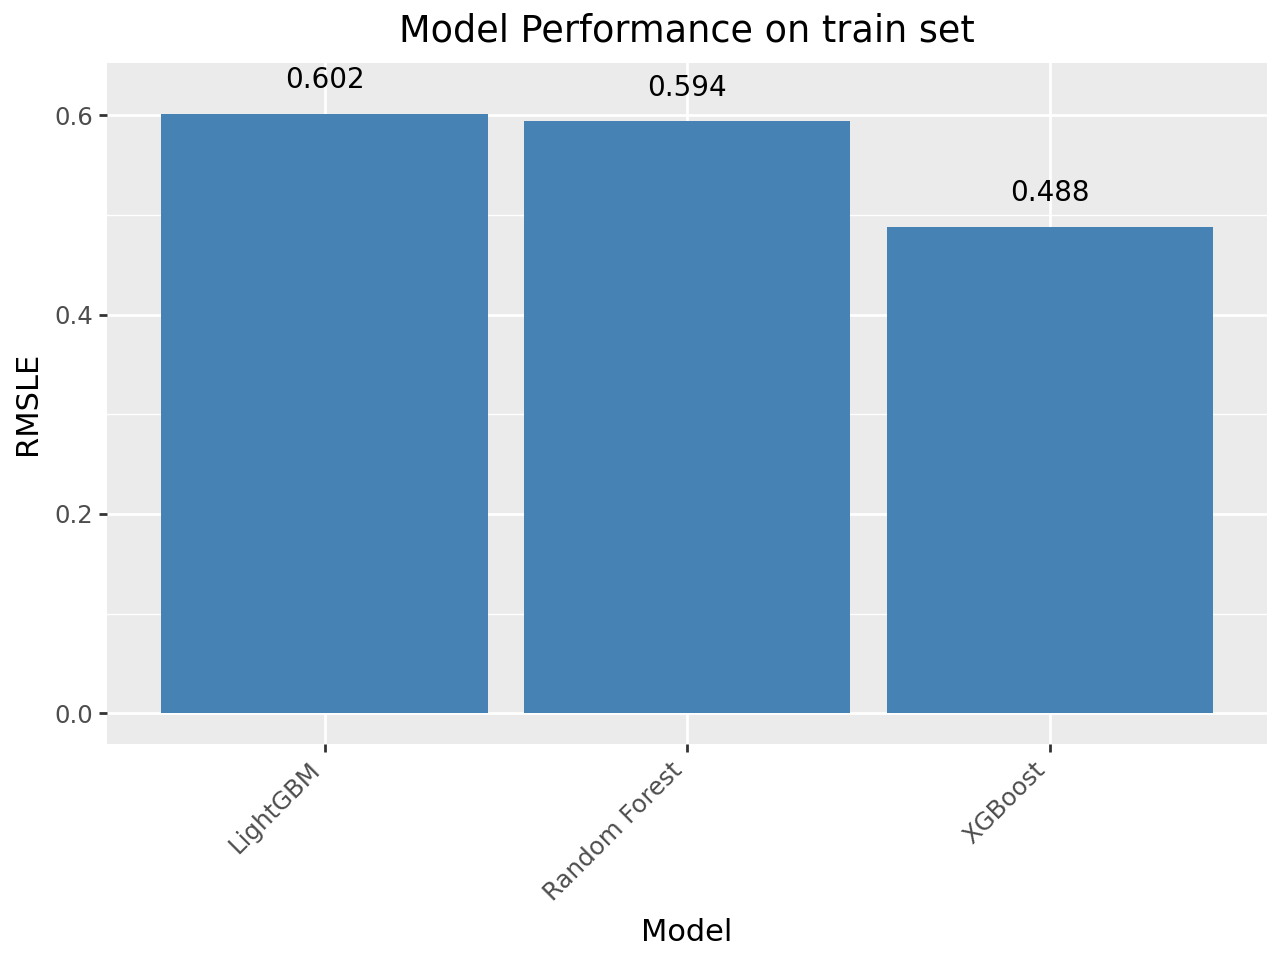

In [ ]:
plot_df = comparison_df.copy()
plot_df['RMSLE'] = plot_df['RMSLE'].round(3)

(ggplot(plot_df, aes('Model', 'RMSLE')) +
 geom_col(fill='steelblue') +
 geom_text(aes(label='RMSLE'), va='bottom', nudge_y=0.02, size=10) +
 ggtitle('Model Performance on train set') +
 xlab('Model') +
 ylab('RMSLE') +
 theme(axis_text_x=element_text(angle=45, hjust=1)))

### Create submissions

In [ ]:
xgb_y_pred = xgb_model.predict(X_test)
rf_y_pred = rf_model.predict(X_test_rf)
lgbm_y_pred = lgbm_model.predict(X_test_cat)

# Create submission files using the saved test IDs
xgb_submission = create_submission(xgb_y_pred, test_ids, 'xgb_submission.csv')
rf_submission = create_submission(rf_y_pred, rf_test_ids, 'rf_submission.csv')
lgbm_submission = create_submission(lgbm_y_pred, cat_test_ids, 'lgbm_submission.csv')

print("All submission files created successfully!")

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


All submission files created successfully!


### Test set accuracy comparisons (taken from Kaggle)

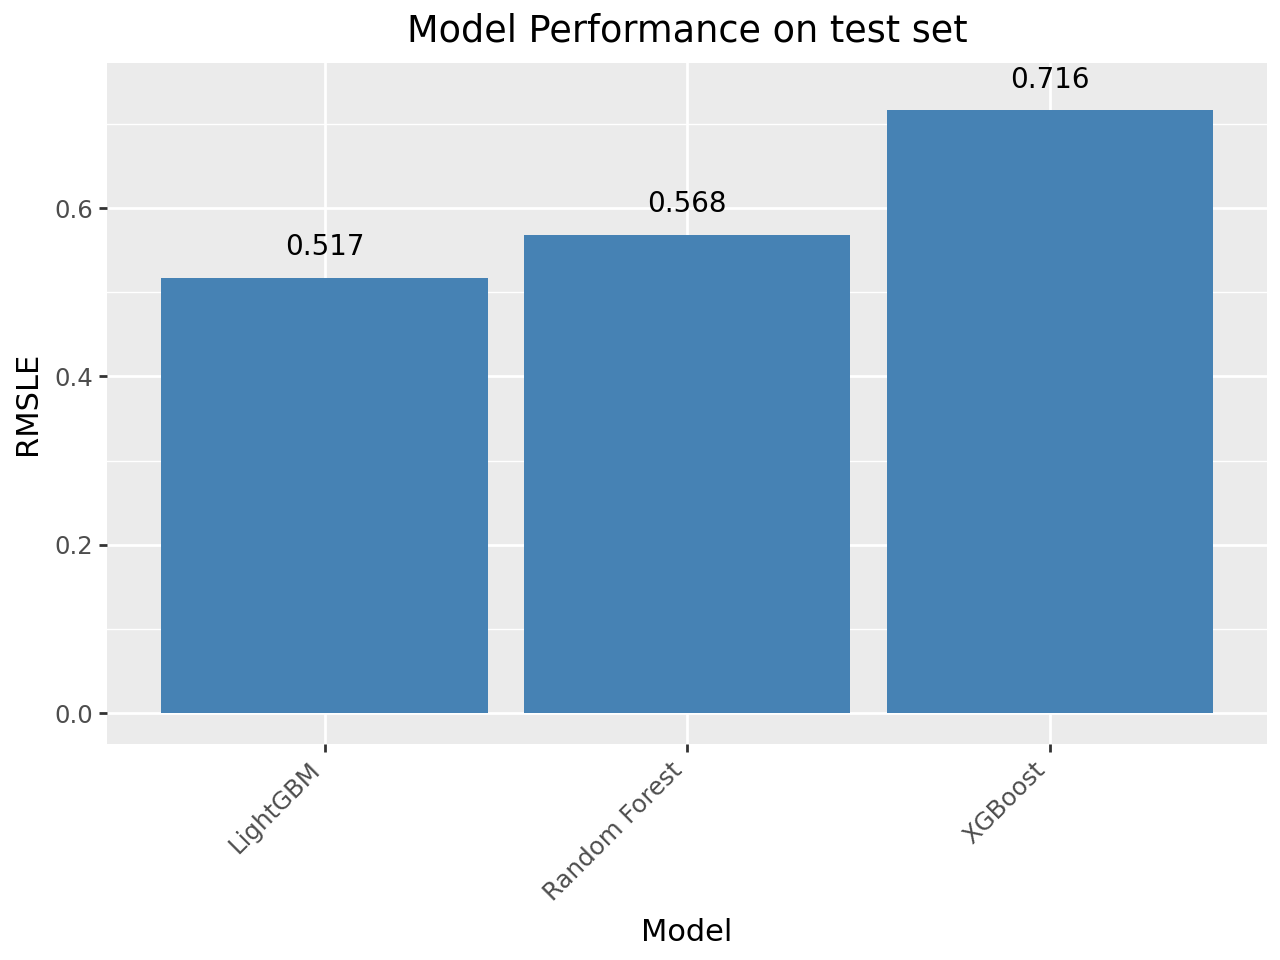

In [ ]:
test_set_comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'LightGBM', 'XGBoost'],
    'RMSLE': [0.56792, 0.51714, 0.71555]
})

plot_df = test_set_comparison_df.copy()
plot_df['RMSLE'] = plot_df['RMSLE'].round(3)

(ggplot(plot_df, aes('Model', 'RMSLE')) +
 geom_col(fill='steelblue') +
 geom_text(aes(label='RMSLE'), va='bottom', nudge_y=0.02, size=10) +
 ggtitle('Model Performance on test set') +
 xlab('Model') +
 ylab('RMSLE') +
 theme(axis_text_x=element_text(angle=45, hjust=1)))

### Model training times

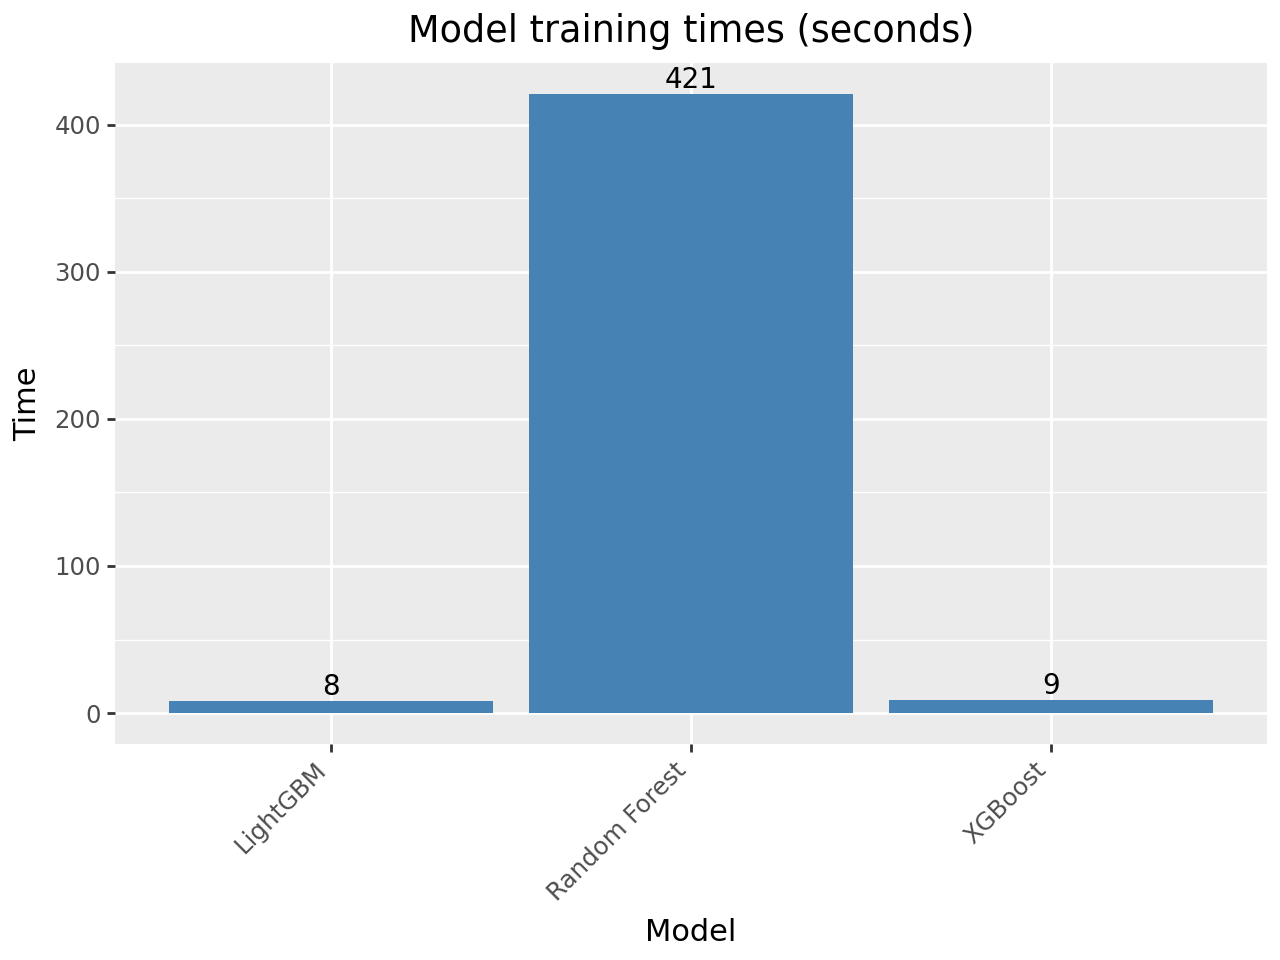

In [ ]:
training_time_comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'LightGBM', 'XGBoost'],
    'Time': [421, 8, 9]
})

(ggplot(training_time_comparison_df, aes('Model', 'Time')) +
 geom_col(fill='steelblue') +
 geom_text(aes(label='Time'), va='bottom', nudge_y=0.02, size=10) +
 ggtitle('Model training times (seconds)') +
 xlab('Model') +
 ylab('Time') +
 theme(axis_text_x=element_text(angle=45, hjust=1)))